After running the notebook to generate the FP-Growth Rules, and the server assignments based on number of servers and ensuring IP pairs are placed on the same server to the extent possible.

We now go back to our origninal dataframe, and add 2 new columns: Src_server and Dst_server, which explicately states where that IP address (or app) should have been scheduled if all other resources were available.

The number of apps per server is set int he 'Rules' notebook. In this instance we assume 20 apps/server.

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
#from apyori import apriori 

In [2]:
#load data

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#load in the server assignment dataframe

server_rules=pd.read_csv('server_rules40.csv')
#these are note in a particular oder, simply sorted by IP address. However, the most important rules are associated with the lower server ids.
#a IP was assigned to the first server based on it's priorety, so server 0 had the top important IPs.

In [4]:
server_rules.head()

,Unnamed: 0,IP,serverid
0,0.0.0.0,0.0.0.0,25.0
1,10001_210,10001_210,36.0
2,10002_13,10002_13,69.0
3,10002_131,10002_131,83.0
4,10003_106,10003_106,7.0


In [5]:
#merge in the serverid

df_servers=df.merge(server_rules.iloc[:,1:3], left_on='Src_IP', right_on='IP', how='left')
df_servers=df_servers.rename(columns={'serverid': 'Src_Server'})

In [6]:
df_servers=df_servers.merge(server_rules.iloc[:,1:3], left_on='Dst_IP', right_on='IP', how='left')
df_servers=df_servers.rename(columns={'serverid': 'Dst_Server'})
df_servers=df_servers.drop(['IP_x', 'IP_y'], axis=1)

In [7]:
#check to see if we get any pairs
df_servers[df_servers['Src_Server']==df_servers['Dst_Server']].head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,Src_Server,Dst_Server
1490,2017-08-02 00:23:54.113,0.997,192.168.100.20,59883,10011_132,25.0,2,148,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",1.0,1.0
1497,2017-08-02 00:23:57.115,0.000,192.168.100.20,59883,10011_132,25.0,1,74,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",1.0,1.0
1727,2017-08-02 00:28:54.340,0.998,192.168.100.20,59886,10011_132,25.0,2,148,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",1.0,1.0
1736,2017-08-02 00:28:57.342,0.000,192.168.100.20,59886,10011_132,25.0,1,74,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",1.0,1.0
3035,2017-08-02 00:58:53.915,0.999,192.168.100.20,59891,10011_132,25.0,2,148,2017-08-02 01:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",1.0,1.0


Great, at least we get some pairs. The percentage of matching pairs from the dataset is:


In [9]:
len(df_servers[df_servers['Src_Server']==df_servers['Dst_Server']])/len(df_servers)

0.015293931389134024

This is not a big percentage, but makes sense because we only made rules for some of the IP pairs that were most critical.
Now, let's go through and change all the durations where we get a matching server pair to be time =0, this assumes they are on the same machine and latency is 0.

In [10]:
df_servers['duration_pred']=df_servers['Duration']
df_servers['duration_pred'][df_servers['Src_Server']==df_servers['Dst_Server']]=0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [97]:
#millions=[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1,2.2, 2.3, 2.4, 2.5,6.5, 44]

millions=[x * 0.1 for x in range(0, 100)]
millions=[round(x,2) for x in millions]
millions2=[x * 0.1 for x in range(100, 1001)]
millions2=[round(x,2) for x in millions2]
millions3=[x * 0.1 for x in range(1000, 10001)]
millions3=[round(x,2) for x in millions3]
#The byte column has mostly numbers, but also some strings which put the numbers into millions

In [98]:
max(millions3)

1000.0

In [92]:
#Need to convert the 1.1M into a integer forrm, so multiply that value by 1million.
strings=[]
for i in millions:
    strings=('   ' +str(i) +' M')
    df_servers['Bytes'][df_servers['Bytes']==strings]=(i*1000000)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
for i in millions2:
    strings=('  ' +str(i) +' M')
    df_servers['Bytes'][df_servers['Bytes']==strings]=(i*1000000)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [99]:
for i in millions3:
    strings=(' ' +str(i) +' M')
    df_servers['Bytes'][df_servers['Bytes']==strings]=(i*1000000)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


KeyboardInterrupt: 

In [94]:
df_servers['Bytes'].apply(lambda x:float(x))

ValueError: could not convert string to float: ' 495.0 M'

In [63]:
strings=[]
for i in millions:
    strings=('   ' +str(i) +' M')
    df_servers['Bytes'][df_servers['Bytes']==strings]=(i*1000000)

df_servers['Bytes'][df_servers['Bytes']=='  44.0 M']=(44*1000000)
df_servers['Bytes'][df_servers['Bytes']=='  56.1 M']=(44*1000000)
489.1 M
82.4 M
171.6 M
278.0 M
 43.5 M
    51.2 M
    143.6 M
    
    91.8 M
    104.8 M
     242.2 M
        276.0 M
         476.0 M
            189.2 M
             189.3 M
                 82.3 M
                     222.4 M
 233.1 M
386.1 M
 142.2 M
     248.5 M
         34.1 M
            32.6 M
            33.1 M
             35.6 M
                28.5 M
                27.3 M
                 30.5 M
                     37.1 M
                        34.0 M

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
df_servers[df_servers['Bytes']=='   1.5 M']

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,Src_Server,Dst_Server
297,2017-08-02 00:04:58.286,0.219,10003_235,80,192.168.210.54,59665.0,558,1.5 M,2017-08-02 00:00:00,"[10003_235, 192.168.210.54]","(10003_235, 192.168.210.54)",NaN,0.0
255163,2017-08-02 09:20:57.083,5.486,192.168.100.11,445,192.168.210.56,39662.0,19330,1.5 M,2017-08-02 09:00:00,"[192.168.100.11, 192.168.210.56]","(192.168.100.11, 192.168.210.56)",NaN,0.0
473851,2017-08-02 10:46:35.955,1.024,10058_166,443,192.168.220.50,40550.0,399,1.5 M,2017-08-02 11:00:00,"[10058_166, 192.168.220.50]","(10058_166, 192.168.220.50)",NaN,2.0
508783,2017-08-02 10:58:31.182,1.911,11486_172,443,192.168.220.46,45314.0,378,1.5 M,2017-08-02 11:00:00,"[11486_172, 192.168.220.46]","(11486_172, 192.168.220.46)",NaN,1.0
581702,2017-08-02 11:31:50.171,0.191,10008_9,80,192.168.210.55,60568.0,567,1.5 M,2017-08-02 12:00:00,"[10008_9, 192.168.210.55]","(10008_9, 192.168.210.55)",NaN,1.0
587504,2017-08-02 11:35:13.753,0.521,10035_14,443,192.168.220.47,35960.0,653,1.5 M,2017-08-02 12:00:00,"[10035_14, 192.168.220.47]","(10035_14, 192.168.220.47)",NaN,0.0
592165,2017-08-02 11:36:23.467,4.735,10035_14,443,192.168.220.51,60139.0,656,1.5 M,2017-08-02 12:00:00,"[10035_14, 192.168.220.51]","(10035_14, 192.168.220.51)",NaN,0.0
615068,2017-08-02 11:47:57.037,0.881,10008_33,80,192.168.220.51,59522.0,400,1.5 M,2017-08-02 12:00:00,"[10008_33, 192.168.220.51]","(10008_33, 192.168.220.51)",NaN,0.0
629432,2017-08-02 11:52:36.777,0.205,10008_9,80,192.168.210.55,39345.0,623,1.5 M,2017-08-02 12:00:00,"[10008_9, 192.168.210.55]","(10008_9, 192.168.210.55)",NaN,1.0
644294,2017-08-02 11:56:07.467,2.607,10823_193,443,192.168.210.53,53015.0,583,1.5 M,2017-08-02 12:00:00,"[10823_193, 192.168.210.53]","(10823_193, 192.168.210.53)",NaN,6.0


In [34]:
df_servers['Bytes'].astype(str).astype(int)

ValueError: invalid literal for int() with base 10: '   1.5 M'

We will use the same logic for determining how many bytes we pay for. We assume apps that are co-located are not using any bandwith, and thus their paid for bytes is set to 0

In [143]:
orig_latency=df_servers['Duration'].sum()
orig_latency#originial total latency

2014119.5810000007

In [144]:
orig_avg_latency=df_servers['Duration'].mean()
orig_avg_latency

0.24604465543092532

In [145]:
model40_latency=df_servers['duration_pred'].sum()
model40_latency#new updated latency with the co-located apps

1889540.067000001

In [146]:
model40_avg_latency=df_servers['duration_pred'].mean()
model40_avg_latency

0.23082603391260523

## How much did our model improve the latency? We made a what % impact?

In [147]:
#percent change 

orig_time=df_servers['Duration'].sum()
pred_time=df_servers['duration_pred'].sum()

(orig_time-pred_time )/orig_time

0.06185308716285187

How does this compare to randomly assigning servers?

In [148]:
#need to assign random servers to the IP addressed, however b/c we did not assign a server to all the IP addresses in our model run, we will only assign servers to the same proportion of the data.

#how many servers did we assign in the Src_server column?
num_src_assign=df_servers['Src_Server'].count()
num_dst_assign=df_servers['Dst_Server'].count()

In [149]:
xx_src=np.random.choice(len(df), num_src_assign) #which rows are randomly assigned src servers
xx_dst=np.random.choice(len(df), num_dst_assign) #which rows are randomly assigned dst servers
num_servers=server_rules['serverid'].nunique()
df_servers['rnd_src_server']=None
df_servers['rnd_dst_server']=None

In [150]:
rnd_src_servers=[]
for x in range(len(xx_src)):
  rnd_src_servers.append(random.randint(0,num_servers))

In [151]:
rnd_dst_servers=[]
for x in range(len(xx_dst)):
  rnd_dst_servers.append(random.randint(0,num_servers)) #create random numbers for dst serve

In [152]:
df_servers['rnd_src_server'][xx_src]=rnd_src_servers
df_servers['rnd_dst_server'][xx_dst]=rnd_dst_servers

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [153]:
len(df_servers[df_servers.rnd_src_server==df_servers.rnd_dst_server])/len(df_servers) #we only get 0.9% matching pairs

0.0019339134462872673

Now, set the matching pairs duration = 0, and sum up the time again, just like before.

In [154]:
df_servers['duration_rnd']=df_servers['Duration']
df_servers['duration_rnd'][df_servers['rnd_src_server']==df_servers['rnd_dst_server']]=0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### How does this completely random assignment compare to our model?

In [155]:
latency_rnd=df_servers['duration_rnd'].sum() #new updated latency with the randomly assigned apps
latency_rnd

2010324.0359999998

In [156]:
latency_rnd_avg=df_servers['duration_rnd'].mean() #new updated latency with the randomly assigned apps
latency_rnd_avg

0.2455809920166425

In [157]:
latency={'total_time':[latency_rnd, orig_latency, model40_latency], 'avg_time':[latency_rnd_avg, orig_avg_latency, model40_avg_latency], 'type':['rnd', 'orig', 'model40']}
latency=pd.DataFrame(latency)
latency

,total_time,avg_time,type
0,2010324.036,0.245581,rnd
1,2014119.581,0.246045,orig
2,1889540.067,0.230826,model40


In [158]:
latency.to_csv('latency_time_40.csv')

In [159]:
(df_servers['Duration'].sum()-df_servers['duration_rnd'].sum())/ df_servers['Duration'].sum() #new updated latency with the random assignment

0.0018844685468557864

The random model only improves things by almost 1%, while our model is around a 6% improvement.

Our model performs how much better than random? A % improvement:

In [160]:
(df_servers['duration_rnd'].sum()-df_servers['duration_pred'].sum() )/df_servers['duration_rnd'].sum()

0.06008184095551394

We saved how many seconds?

In [161]:
df_servers['duration_rnd'].sum() - df_servers['duration_pred'].sum()

120783.96899999888

In [162]:
#export csv

df_servers.to_csv('df_servers40.csv')

Let's make an hour timestep and see how total latency varies over time

In [163]:
hour_totals=df_servers.groupby(['date_hr'],as_index=False)[['Duration', 'duration_pred']].sum()

#hour_group2=df.groupby(['date_hr', 'pairs2'], as_index=False)['Date'].count()

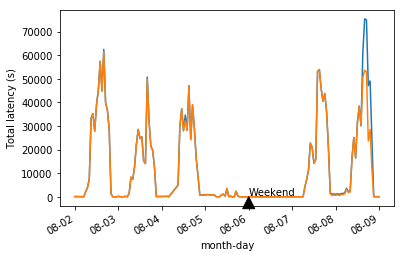

In [164]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(hour_totals['date_hr'], hour_totals['Duration'])
ax.plot(hour_totals['date_hr'], hour_totals['duration_pred'])

myFmt = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('month-day')
plt.show()

How many seconds are we saving each hour?

In [165]:
hour_totals['time_saved']=hour_totals['Duration']-hour_totals['duration_pred']

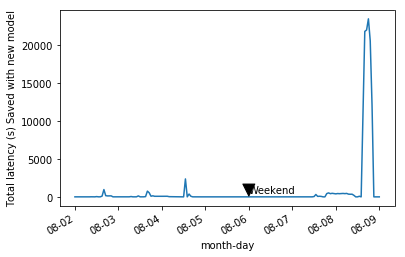

In [166]:
fig, ax = plt.subplots()
ax.plot(hour_totals['date_hr'], hour_totals['time_saved'])

myFmt = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s) Saved with new model')
plt.xlabel('month-day')
plt.show()

Hmmmm what's happening in the last day?

### What if we only implement a sub-set of the rules?
These results are for all of the rules generated by the FP-Growth algorithm being implemented. This is ~300 rules. If we do not want to implement them all, because of cost and resources, we could implement them in batches. The servers were assigned based on highest priorety rules being put in a server first. So server "1" has the IP addresses that are most valuable to be co-located, the IPs assigned to higher number servers (e.g., 20) are less important.

Let's see if we implement each batch of rules, how close we get to our total benefit.
Here % = time saved with this batch of rules / total time saved with all rules implemented

In [167]:
df_servers_list=[]

batch=pd.DataFrame()
serverid=0
#memory error, lets only do a subset, if i=5 we use servers 0-5
percent_rules=[0.05, 0.25, 0.5, 0.75, 1]

server_batches=[server_rules.serverid.nunique()*x for x in percent_rules]
server_batches=[round(x) for x in server_batches]
server_batches

for i in server_batches:
    batch=df.merge(server_rules[server_rules['serverid']<=i].iloc[:,1:3], left_on='Src_IP', right_on='IP', how='left')
    batch=batch.rename(columns={'serverid': 'Src_Server'})
    batch=batch.merge(server_rules[server_rules['serverid']<=i].iloc[:,1:3], left_on='Dst_IP', right_on='IP', how='left')
    batch=batch.rename(columns={'serverid': 'Dst_Server'})
    df_servers_list.append(batch)



KeyboardInterrupt: 

In [ ]:
latency_avg=[]
latency_totals=[]
for i in range(len(df_servers_list)):
    df_server=df_servers_list[i]
    df_server['duration_pred']=df_server['Duration']
    df_server['duration_pred'][df_server['Src_Server']==df_servers['Dst_Server']]=0
    total_time=df_server['duration_pred'].sum()
    avg_time=df_server['duration_pred'].mean()
    latency_totals.append(total_time)
    latency_avg.append(avg_time)

In [ ]:
percent_rules

In [ ]:
apps_server=20
num_rules=[x*apps_server for x in server_batches]
latency_matrix={'latency_total':latency_totals, 'latency_avg':latency_avg, 'percent_rules':percent_rules, 'num_rules': num_rules}
latency_matrix=pd.DataFrame.from_dict(latency_matrix)
latency_matrix['model']='per40_70con'
latency_matrix

In [ ]:
latency_matrix.to_csv('latency_matrix_40_70con.csv')